In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
import xwmt
import xarray as xr
import numpy as np
import xgcm

import matplotlib.pyplot as plt

In [226]:
def idealized_wmt_experiment(lam_profile, heating_local, wmt_local, heating_layer, wmt_layer, dz=1.e-3, dlam=1.25e-1):
    bins = np.arange(0., 1.+dlam, dlam)
    
    ds = xr.Dataset()
    ds = ds.assign_coords({
        'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
        'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
    })
    ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})
    ds['heating_rate'] = xr.DataArray(heating_layer(ds.z_i), coords=(ds.z_l,))*ds.dz
    ds['theta'] = xr.DataArray(lam_profile(ds.z_l.data), coords=(ds.z_l,))

    # expand to horizontal dimension and add grid metrics
    ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
    ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

    metrics = {
        ('Z',): ['dz'], # Z distances
        ('X', 'Y'): ['rA'] # Areas
    }
    coords = {
        'X': {'center': 'x',},
        'Y': {'center': 'y',},
        'Z': {'center': 'z_l', 'outer': 'z_i'},
    }
    grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])
    
    budget_dict = {
        'heat': {
            'lambda': 'theta',
            'lhs': {'tendency':'heating_rate'},
            'rhs': {}
        },
        'salt': {
            'lambda':'salt',
            'rhs': {},
            'lhs': {}
        }
    }

    wmt = xwmt.WaterMassTransformations(ds, grid, budget_dict, cp=1., rho_ref=1.)
    wmts = wmt.integrate_transformations("temperature", bins=bins, sum_components=False)

    fig, axes = plt.subplots(1,3,figsize=(10, 5))
    plt.sca(axes[0])
    plt.step(np.append(ds["heating_rate"].mean(["x", "y"]), 0), ds.z_i.values, where="pre", color="k", label="layer-integrated")
    if ds.z_i.size<=20:
        for b in ds.z_i.values:
            plt.axhline(b, color='k', alpha=0.15, lw=0.25)
    plt.ylim(0, 1)
    plt.xlabel("heating rate")
    plt.ylabel("depth")
    plt.title("")

    plt.sca(axes[1])
    ds['theta'].plot(y="z_l", linewidth=0., alpha=0.5, marker=".", label="theta levels")
    ds['theta_i'] = (
        grid.interp(ds.theta, "Z", boundary="extend")
        .chunk({grid.axes['Z'].coords['outer']: -1})
        .rename(f"{ds.theta.name}_i")
    )
    ds['theta_i'].plot(y="z_i", marker="+", linewidth=0., alpha=0.5, label="theta interfaces")
    if ds.z_i.size<=20:
        for b in ds.z_i.values:
            plt.axhline(b, color='k', alpha=0.15, lw=0.25)
    if len(bins)<=20:
        for b in bins:
            plt.axvline(b, color='k', alpha=0.15, lw=0.25)
    plt.axvline(np.nan, color='k', alpha=0.15, lw=0.25, label="theta bins")
    plt.xlabel("temperature")
    plt.ylabel("depth")
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.title("")
    plt.legend()

    plt.sca(axes[2])
    lam = wmts.theta
    dlam_analytical = 1.e-5
    lam_analytical = np.arange(dlam_analytical/2, 1., dlam_analytical)
    plt.plot(wmt_local(lam_analytical), lam_analytical, color="C3", ls="-", label="analytical (local)", alpha=0.5, lw=3)

    plt.step(np.append(wmts["heating_rate"], [0]), bins, where="pre", label="xwmt output")
    plt.step(np.append(wmt_layer(bins), [0]), bins, ls="--", color="C3", label="analytical (layer-averaged)")
    
    if len(bins)<=20:
        for b in bins:
            plt.axhline(b, color='k', alpha=0.15, lw=0.25)

    plt.ylim(0, 1)

    plt.legend()
    plt.ylim(0, 1)
    plt.ylabel("temperature")
    plt.xlabel("water mass transformation rates")
    plt.tight_layout()
    
    error = wmts["heating_rate"] - wmt_layer(bins)
    abs_rel_err = (np.abs(error)/np.abs(wmt_layer(bins))).mean(skipna=True).values
    print(f"Mean absolute relative error: {abs_rel_err}")
    
    return fig, axes

### Simple test experiments

In [227]:
def idealized_diffusion_local(z):
    return np.sin(2*np.pi*z)
def idealized_diffusion_layer(z_i):
    def f(z):
        return -np.cos(2*np.pi*z)/(2*np.pi)
    return np.diff(f(z_i))/np.diff(z_i)

def idealized_heating_local(z):
    return xr.ones_like(z)
def idealized_heating_layer(z_i):
    return np.diff(z_i)/np.diff(z_i)

def idealized_heating_diffusion_local(z):
    return idealized_diffusion_local(z) + idealized_heating_local(z)
def idealized_heating_diffusion_layer(z_i):
    return idealized_diffusion_layer(z_i) + idealized_heating_layer(z_i)

### Constant stratification

In [228]:
def lam_const_dlamdz(z):
    return z

def wmt_local_const_dlamdz(lam):
    return np.sin(2*np.pi*lam) + 1.

def wmt_layer_const_dlamdz(lam_bins):
    def f(lam):
        return -np.cos(2*np.pi*lam)/(2*np.pi) + lam
    return np.diff(f(lam_bins))/np.diff(lam_bins)

### Case 1: `dz` = `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 1.0977506833085008e-15


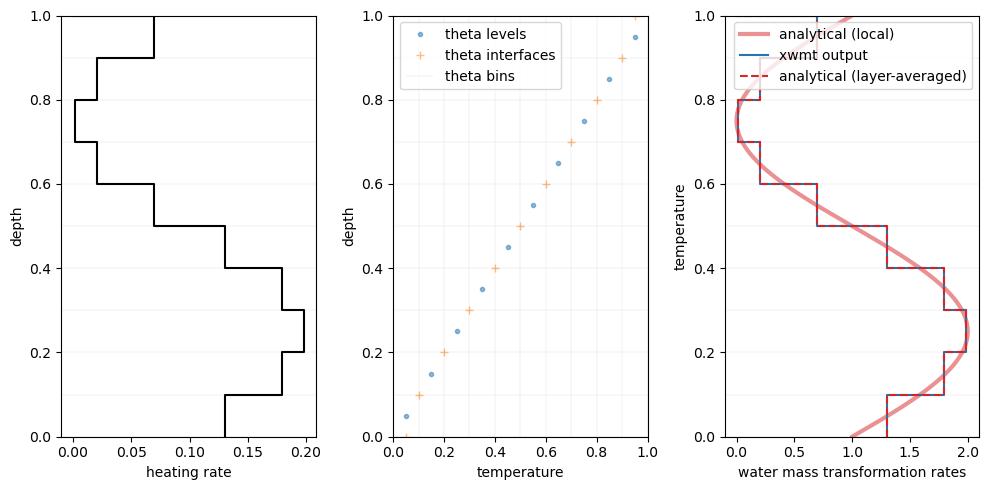

In [229]:
idealized_wmt_experiment(
    lam_const_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_const_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_const_dlamdz,
    dz = 1.e-1,
    dlam = 1.e-1
);

### Case 2: `dz` ~ `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 0.0946718317261388


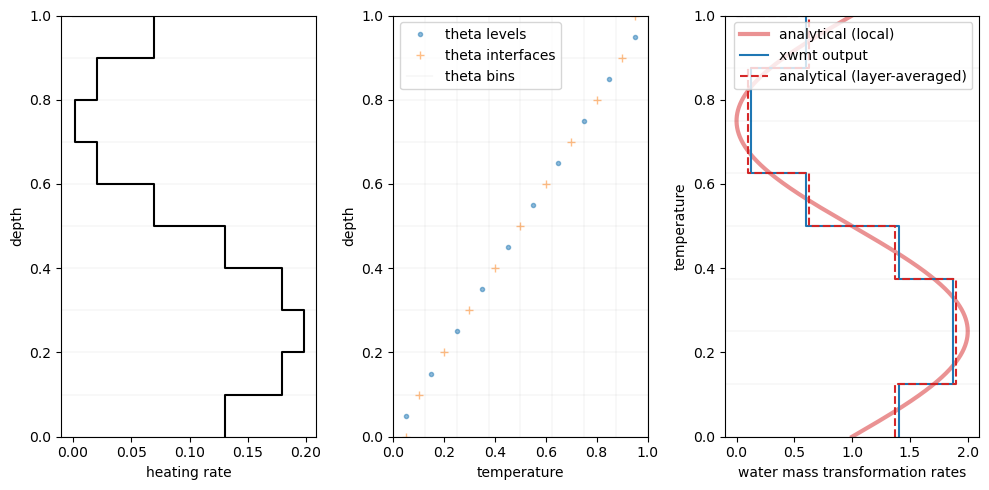

In [230]:
idealized_wmt_experiment(
    lam_const_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_const_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_const_dlamdz,
    dz = 1.e-1,
    dlam = 1.25e-1
);

### Case 3: `dz` < `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 0.0014306054962227755


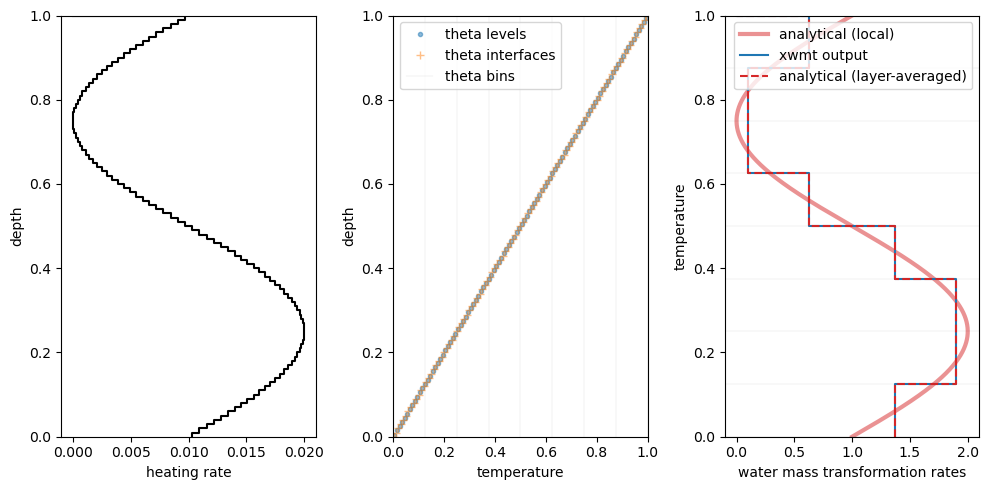

In [231]:
idealized_wmt_experiment(
    lam_const_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_const_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_const_dlamdz,
    dz = 1.e-2,
    dlam = 1.25e-1
);

### Case 4: `dz` << `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 1.078476915651918e-06


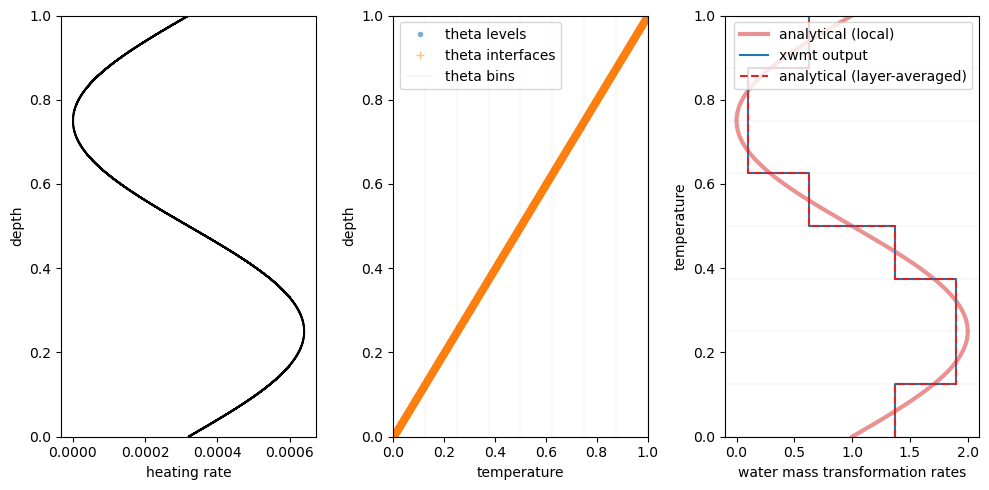

In [232]:
idealized_wmt_experiment(
    lam_const_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_const_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_const_dlamdz,
    dz = 1/(5**5),
    dlam = 1/(2**3)
);

### Case 5: `dz` >> `dlam`

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 3.9059759308208624


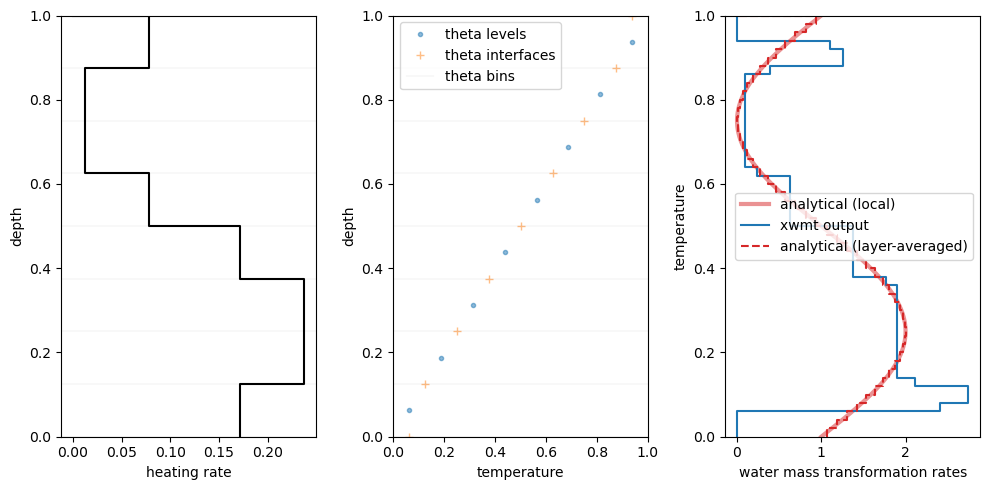

In [233]:
idealized_wmt_experiment(
    lam_const_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_const_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_const_dlamdz,
    dz = 1.25e-1,
    dlam = 2.e-2
);

### Effects of varying, vanishing, or negative stratification

In [234]:
dz = 1/(5**4)
dlam = 1/(2**4)

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 5.330096807378877e-05


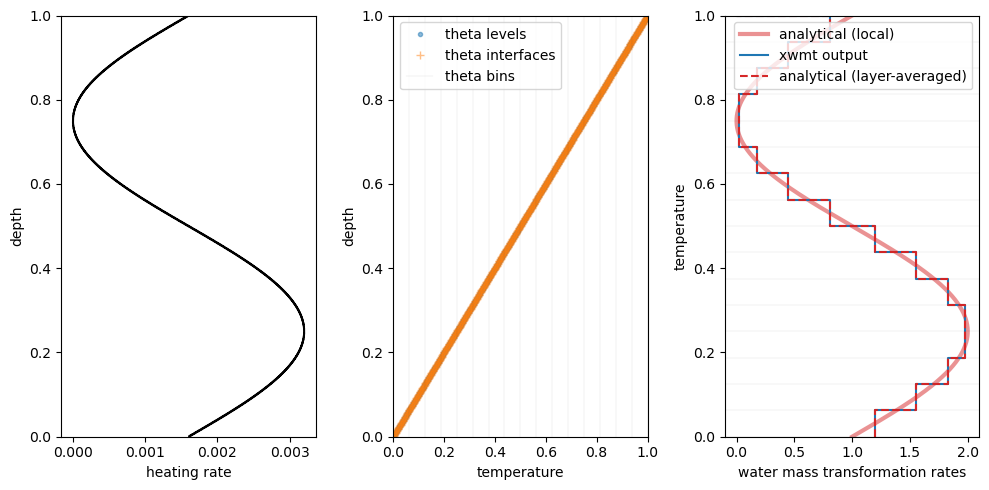

In [235]:
idealized_wmt_experiment(
    lam_const_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_const_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_const_dlamdz,
    dz=dz,
    dlam=dlam
);

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 8.317092892346875e-05


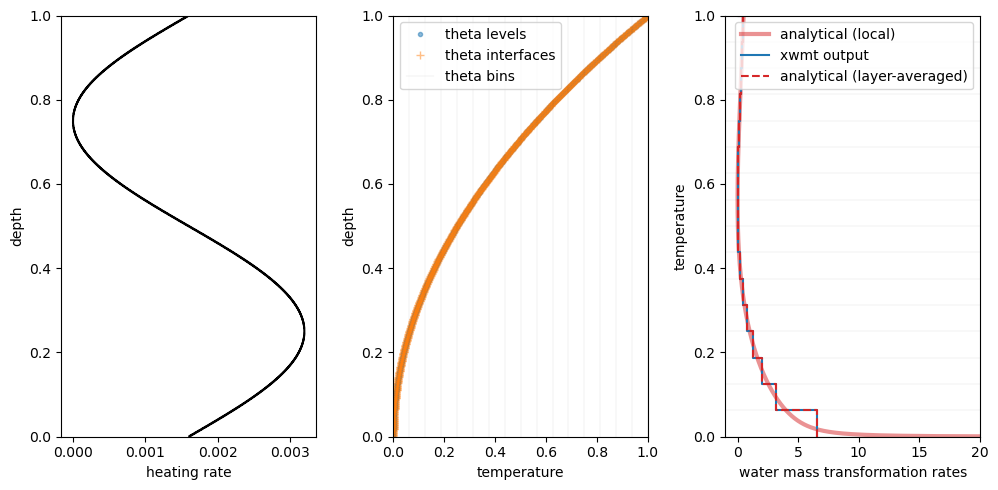

In [236]:
def lam_linear_dlamdz(z):
    return z**2

def wmt_local_linear_dlamdz(lam):
    return (np.sin(2*np.pi*np.sqrt(lam)) + 1.)/(2*np.sqrt(lam))

def wmt_layer_linear_dlamdz(lam_bins):
    def f(lam):
        return -np.cos(2*np.pi*np.sqrt(lam))/(2*np.pi) + np.sqrt(lam)
    return np.diff(f(lam_bins))/np.diff(lam_bins)

fig, axes = idealized_wmt_experiment(
    lam_linear_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_linear_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_linear_dlamdz,
    dz=dz,
    dlam=dlam
);
axes[2].set_xlim(-1, 20);

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 1.8692949015868274e-05


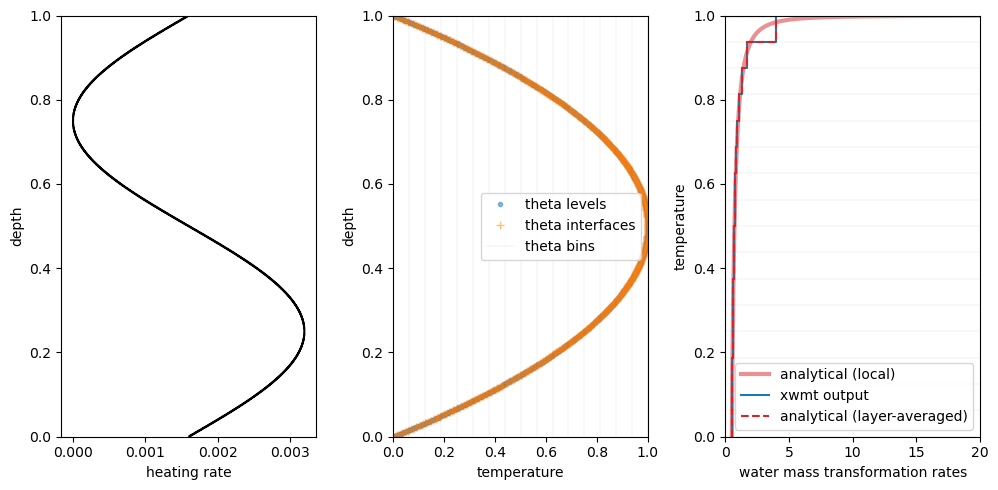

In [237]:
def lam_overturning_dlamdz(z):
    return 1 - (2*z - 1)**2

def wmt_local_overturning_dlamdz(lam):
    return 1/(2*np.sqrt(1-lam))

def wmt_layer_overturning_dlamdz(lam_bins):
    def f(lam):
        return 1 - np.sqrt(1 - lam)
    return np.diff(f(lam_bins))/np.diff(lam_bins)

fig, axes = idealized_wmt_experiment(
    lam_overturning_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_overturning_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_overturning_dlamdz,
    dz=dz,
    dlam=dlam
);
axes[2].set_xlim(0, 20);

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vftmp/Henri.Drake/pid10414/ipykernel_11763/117533391.py:21: RuntimeWarning: invalid value encountered in sqrt
  u = 1 + sign*np.sqrt(sign*(1-2*lam))


Mean absolute relative error: nan


/vftmp/Henri.Drake/pid10414/ipykernel_11763/117533391.py:21: RuntimeWarning: invalid value encountered in sqrt
  u = 1 + sign*np.sqrt(sign*(1-2*lam))


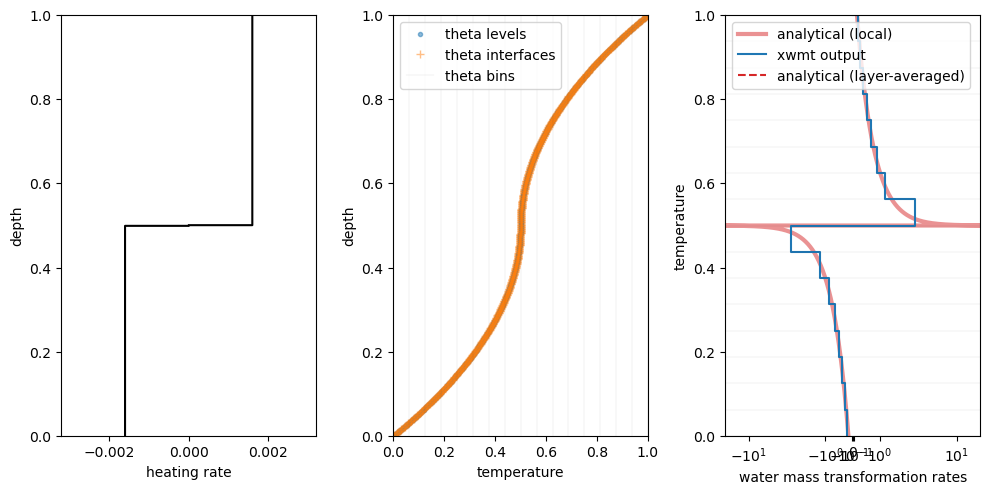

In [261]:
def lam_vanishing_dlamdz(z):
    sign = 2*np.float64(z>0.5)-1
    return (1 + sign*(2*z - 1)**2)/2.

def differential_heating_local(z):
    return (2*np.float64(z>0.5)-1)

def wmt_local_vanishing_dlamdz(lam):
    sign = 2*np.float64(lam>0.5)-1
    return sign/(2*np.sqrt(sign*(2*lam-1)))

def differential_heating_layer(z_i):
    sign = 2*np.float64(z_i>0.5)-1
    out = np.diff(sign*z_i)/np.diff(z_i)
    out[(z_i[:-1].values<=0.5)&(0.5<=z_i.values[1:])] = 0.
    return out

def wmt_layer_vanishing_dlamdz(lam_bins):
    def f(lam):
        sign = 2*np.float64(lam>0.5)-1
        u = 1 + sign*np.sqrt(sign*(1-2*lam))
        return 0.5*u
    out = np.diff(f(lam_bins))/np.diff(lam_bins)
    out[(lam_bins[:-1]<=0.5)&(0.5<=lam_bins[1:])] = np.nan
    return out

fig, axes = idealized_wmt_experiment(
    lam_vanishing_dlamdz,
    differential_heating_local,
    wmt_local_vanishing_dlamdz,
    differential_heating_layer,
    wmt_layer_vanishing_dlamdz,
    dz=dz,
    dlam=dlam
);
axes[2].set_xlim(-20, 20);
axes[2].set_xscale("symlog", linthresh=0.5, linscale=0.05)
axes[2].legend(loc="upper left")

### Convergence of results as grid spacing decreases

In [264]:
dz=2.e-5
dlam=2.e-5

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


Mean absolute relative error: 8.847595131222918e-05


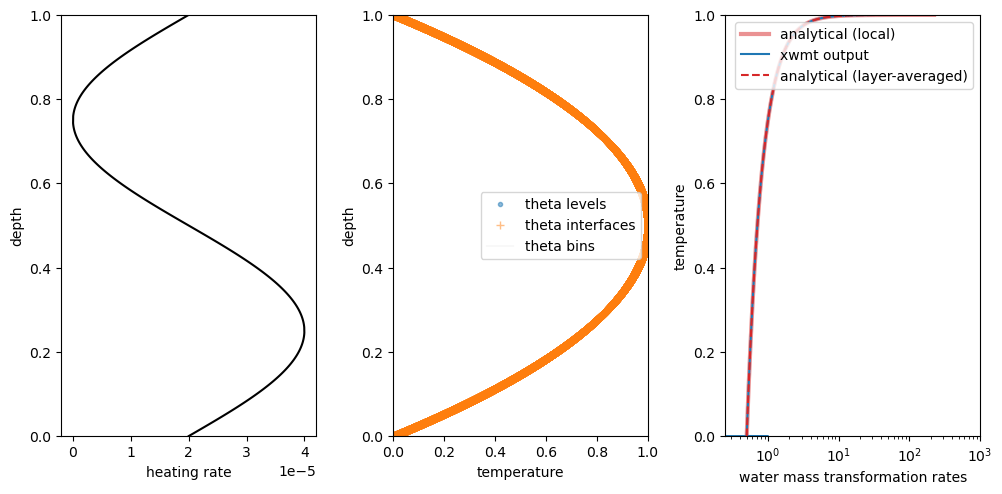

In [265]:
fig, axes = idealized_wmt_experiment(
    lam_overturning_dlamdz,
    idealized_heating_diffusion_local,
    wmt_local_overturning_dlamdz,
    idealized_heating_diffusion_layer,
    wmt_layer_overturning_dlamdz,
    dz=dz,
    dlam=dz
);
axes[2].set_xlim(0.25, 1e3);
axes[2].set_xscale("log")

/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/work/hfd/.conda/envs/generic-xstack/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vftmp/Henri.Drake/pid10414/ipykernel_11763/117533391.py:21: RuntimeWarning: invalid value encountered in sqrt
  u = 1 + sign*np.sqrt(sign*(1-2*lam))
/vftmp/Henri.Drake/pid10414/ipykernel_11763/117533391.py:21: RuntimeWarning: invalid value encountered in sqrt
  u = 1 + sign*np.sqrt(sign*(1-2*lam))


Mean absolute relative error: nan


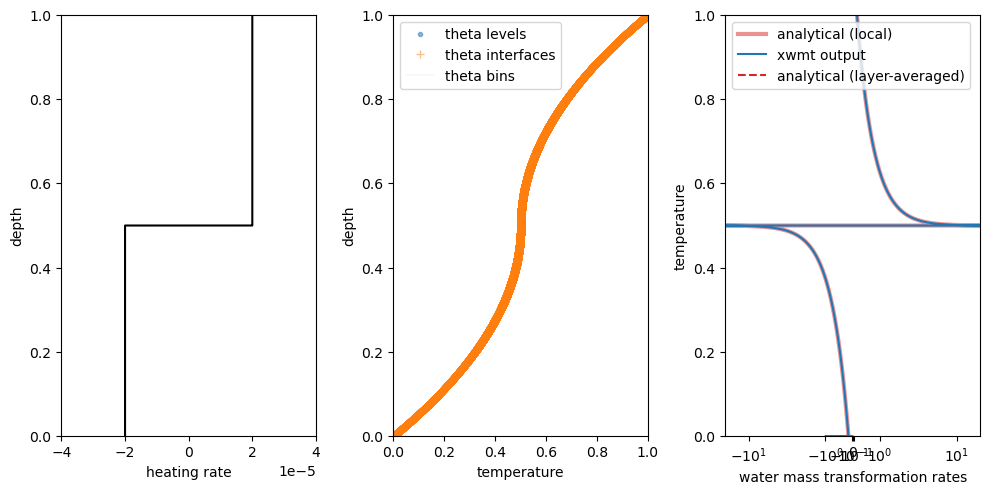

In [266]:
fig, axes = idealized_wmt_experiment(
    lam_vanishing_dlamdz,
    differential_heating_local,
    wmt_local_vanishing_dlamdz,
    differential_heating_layer,
    wmt_layer_vanishing_dlamdz,
    dz=dz,
    dlam=dz
);
axes[2].set_xlim(-20, 20);
axes[2].set_xscale("symlog", linthresh=0.5, linscale=0.05)
axes[2].legend(loc="upper left")